###setup

In [302]:
%matplotlib inline

In [303]:
from numpy import array, inf, maximum
import matplotlib.pyplot as plt
import seaborn as sns

In [304]:
import thunder
from showit import image, tile
import matplotlib.animation as animation

In [305]:
from os.path import join, exists
from os import mkdir, makedirs
import pandas as pd

In [306]:
import regression

In [307]:
from skimage.io import imread, imsave

###set directory and session information

In [308]:
directory = '/tier2/freeman/Nick/lfov.calibration'

In [309]:
key = '2016-05-15'
name = '5001-L23'

In [310]:
path = join(directory, 'reprocessed', name, key)

In [311]:
pixelsPerUm = 600.0/256
frameRate = 2.7
scaleBar = 100

In [312]:
savepath = join(directory, 'reprocessed', name, key, 'summary')

###load covariates

In [313]:
covariates = pd.read_csv(join(path, 'covariates','covariates.csv'))

###load data

In [314]:
data = thunder.images.frombinary(join(path, 'images'), engine=sc, npartitions = 1000)

In [315]:
from numpy import arange, polyfit, polyval

In [316]:
def detrend(y, order=5):
        """
        Detrend series data with linear or nonlinear detrending.
        Preserve intercept so that subsequent operations can adjust the baseline.
        Parameters
        ----------
        method : str, optional, default = 'linear'
            Detrending method
        order : int, optional, default = 5
            Order of polynomial, for non-linear detrending only
        """

        x = arange(len(y))
        p = polyfit(x, y, order)
        p[-1] = 0
        yy = polyval(p, x)
        return y - yy

In [317]:
detrended = data.map_as_series(lambda x: detrend(x))

In [318]:
detrended.cache()
detrended.compute()

In [319]:
records = detrended.toseries()

In [320]:
records.cache()
records.compute()

In [321]:
avg = detrended.map(lambda x: x.mean()).toarray()

In [322]:
avg.shape

(5846,)

In [323]:
len(covariates)

5846

(0, 500)

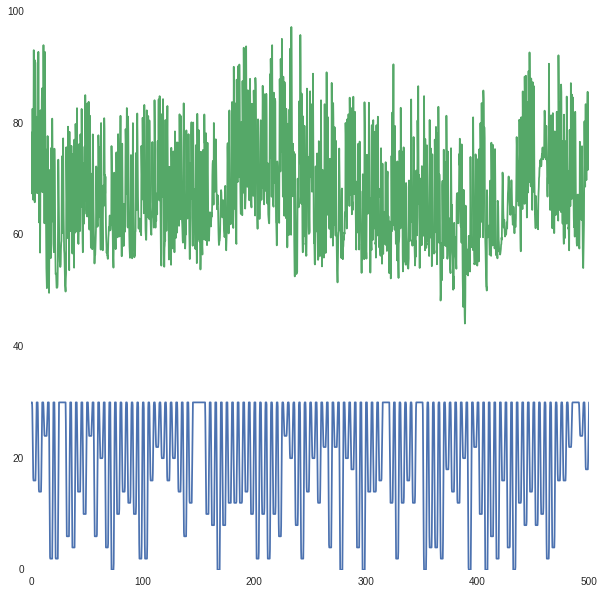

In [324]:
plt.figure(figsize=(10,10))
plt.plot(covariates.allTime, covariates.corPos);
plt.plot(covariates.allTime, avg/5-40);
plt.xlim([0, 500])

##Pixelwise regression demo

In [325]:
import numpy as np
from matplotlib.pyplot import get_cmap
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, Normalize
from regression import LinearRegression

In [326]:
def build_reg(value, scale, debug=False):
    max_val = np.floor(max(value)/scale)*scale
    min_val = np.ceil(min(value)/scale)*scale
    bins = np.arange(min_val,max_val,scale)
    bins = np.concatenate((bins, [np.Inf]))
    design_mat = np.zeros([bins.shape[0] - 1,value.shape[0]])
    for bb in range(bins.shape[0] - 1):
        design_mat[bb,:] = (value >= bins[bb]) & (value < bins[bb+1])
    bins = bins[:-1]
    if debug:
        print 'bins:'
        print bins
        print 'repeats:'
        print design_mat.sum(axis=1)
    return bins, design_mat.transpose()

In [327]:
def do_reg(data, design_mat, bins):
    algorithm = LinearRegression(fit_intercept=False)
    model, rsq = algorithm.fit_and_score(design_mat, data)
    tune = model.betas.map(lambda b: sum(b.clip(0, inf)[1:]*bins)/sum(b.clip(0, inf)[1:]))
    return tune.toarray(), rsq.toarray()

In [328]:
def make_map(rsq, tune, cmap=None, vmin=0, vmax=inf, rmin=0, rmax=0.05):
    cmap = get_cmap('rainbow') if cmap is None else cmap
    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
    img = norm(tune.copy())
    mapped = cmap(img)[:, :, 0:3]
    for i in range(3):
        mapped[:, :, i] *= (rsq.clip(rmin, rmax) - rmin) / (rmax - rmin)
    return mapped

In [329]:
def make_rsq_map(rsq, cmap=None, vmin=0, vmax=inf, threshold=0.05):
    cmap = get_cmap('rainbow') if cmap is None else cmap
    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
    img = norm(rsq.copy())
    mapped = cmap(img)[:, :, 0:3]
    return mapped

### speed tuning maps

In [330]:
bins, design_mat = build_reg(covariates.speed.values, 4, debug=True)

bins:
[  0.   4.   8.  12.  16.]
repeats:
[ 5702.    29.    36.    44.    35.]


In [331]:
tuning_speed, rsq_speed = do_reg(records, design_mat, bins)

In [332]:
from numpy import asarray

In [333]:
cmap = LinearSegmentedColormap.from_list('blend', [[0, 0, 0], [0.9, 0.25, 0.1]])
mapped_speed = make_rsq_map(rsq_speed, vmin=0.0, vmax=0.2, cmap=cmap)
#mapped_speed = asarray([make_rsq_map(x, vmin=0.0, vmax=0.06, cmap=cmap) for x in rsq_speed])

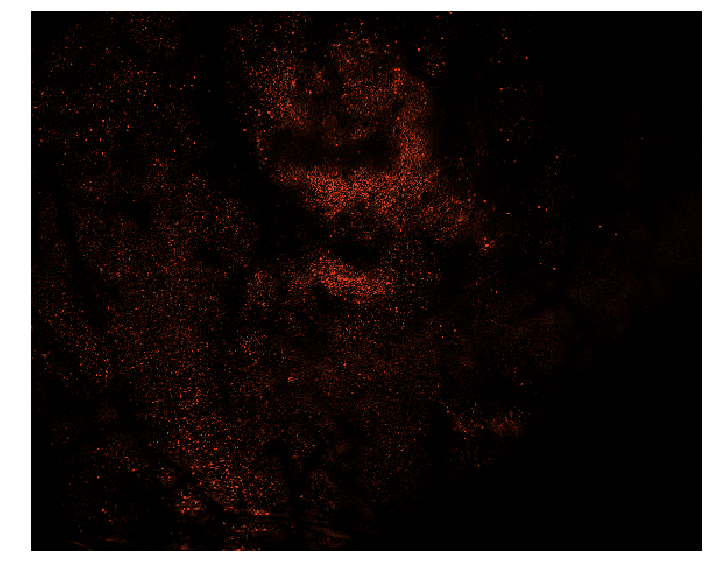

In [334]:
image(mapped_speed, size=12)

In [335]:
imsave(savepath+'/rsqSpeedD.tif', (255*mapped_speed.clip(0,1)).astype('uint8'), plugin='tifffile', photometric='rgb')

In [336]:
#mapped_speed = imread(savepath+'/rsqSpeedD.tif', plugin='tifffile').astype('float32')/255

###corridor position maps running

In [337]:
records2 = detrended[np.where(covariates.speed.values>0)].toseries()
records2.cache()

Series
mode: spark
dtype: float64
shape: (464, 576, 273)

In [338]:
bins, design_mat = build_reg(covariates.corPos.values[covariates.speed.values>0], 4, debug=True)

bins:
[  0.   4.   8.  12.  16.  20.  24.]
repeats:
[  33.   16.    6.    9.   57.   14.  138.]


In [339]:
tuning_corposR, rsq_corposR = do_reg(records2, design_mat, bins)

In [340]:
cmap = LinearSegmentedColormap.from_list('blend', [[0, 0, 0], [0.3, 0.7, 1.0]])
mapped_corposR = make_rsq_map(rsq_corposR, vmin=0.02, vmax=0.15, cmap=cmap)
#mapped_corposR = asarray([make_rsq_map(x, vmin=0.02, vmax=0.15, cmap=cmap) for x in rsq_corposR])

In [341]:
#mapped_corposR = imread(savepath+'/rsqCorPosRD.tif', plugin='tifffile').astype('float32')/255

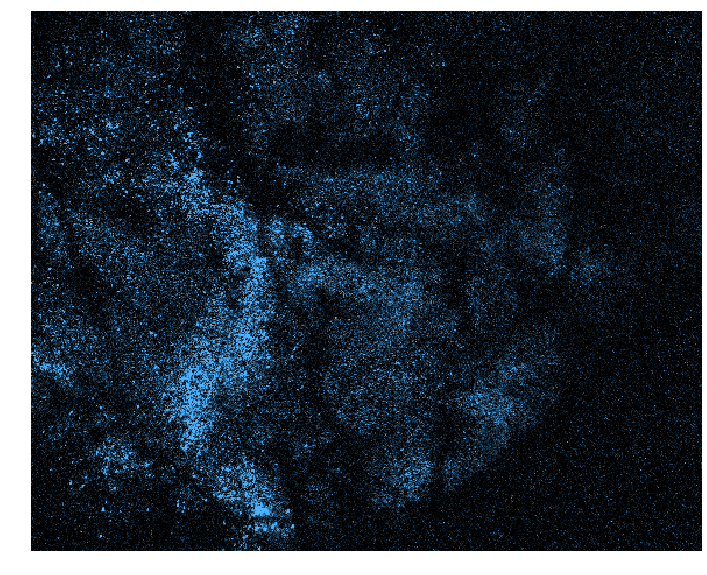

In [342]:
image(mapped_corposR, size=12);

In [343]:
imsave(savepath+'/rsqCorPosRD.tif', (255*mapped_corposR.clip(0,1)).astype('uint8'), plugin='tifffile', photometric='rgb')

In [344]:
mappedR = make_map(rsq_corposR, tuning_corposR, vmin=10.5, vmax = 13.5, rmin=0.02, rmax=0.15)
#mappedR = asarray([make_map(rsq_corposR[i], tuning_corposR[i], vmin=10.5, vmax = 13.5, rmin=0.02, rmax=0.15) for i in range(2)])

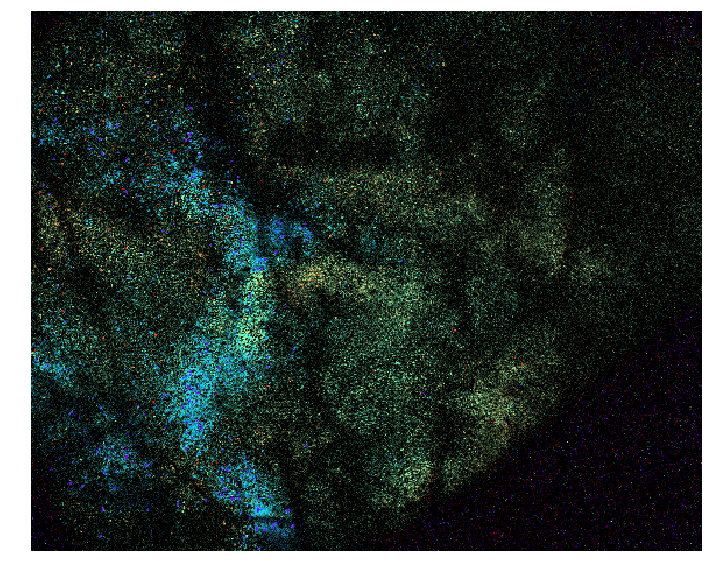

In [345]:
image(mappedR.clip(0,1), size=12);

In [346]:
imsave(savepath+'/tuneCorPosRD.tif', (255*mappedR.clip(0,1)).astype('uint8'), plugin='tifffile', photometric='rgb')

### corridor position maps

In [347]:
bins, design_mat = build_reg(covariates.corPos.values, 4, debug=True)

bins:
[  0.   4.   8.  12.  16.  20.  24.]
repeats:
[  363.   502.   491.   509.   598.   778.  2605.]


In [348]:
tuning_corpos, rsq_corpos = do_reg(records, design_mat, bins)

In [349]:
cmap = LinearSegmentedColormap.from_list('blend', [[0, 0, 0], [0.3, 0.7, 1.0]])
mapped_corpos = make_rsq_map(rsq_corpos, vmin=0.0, vmax=0.05, cmap=cmap)
#mapped_corpos = asarray([make_rsq_map(x, vmin=0.0, vmax=0.02, cmap=cmap) for x in rsq_corpos])

In [350]:
#plt.hist(tuning_corpos[rsq_corpos>.0005].flatten())

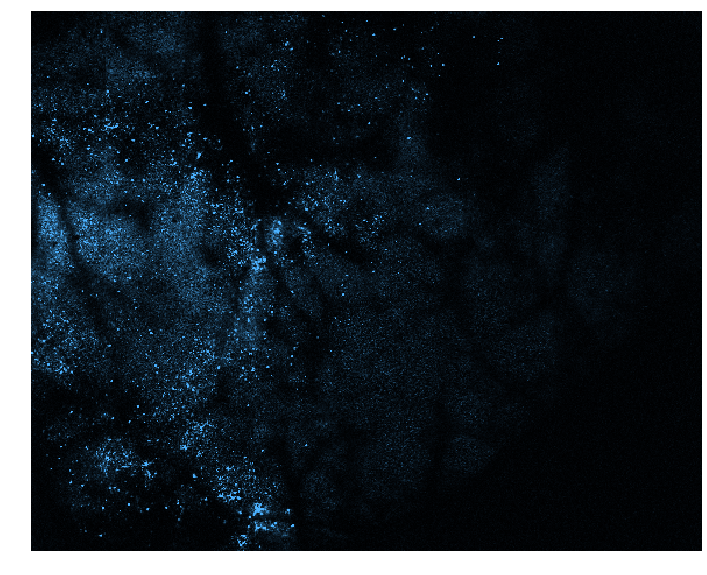

In [351]:
image(mapped_corpos, size=12);

In [352]:
imsave(savepath+'/rsqCorPosAD.tif', (255*mapped_corpos.clip(0,1)).astype('uint8'), plugin='tifffile', photometric='rgb')

In [353]:
#mapped_corpos = imread(savepath+'/rsqCorPosAD.tif', plugin='tifffile').astype('float32')/255

In [354]:
mapped = make_map(rsq_corpos, tuning_corpos, vmin=10.5, vmax = 13.5, rmin=0, rmax=0.05)
#mapped = asarray([make_map(rsq_corpos[i], tuning_corpos[i], vmin=10.5, vmax = 13.5, rmin=0, rmax=0.02) for i in range(2)])

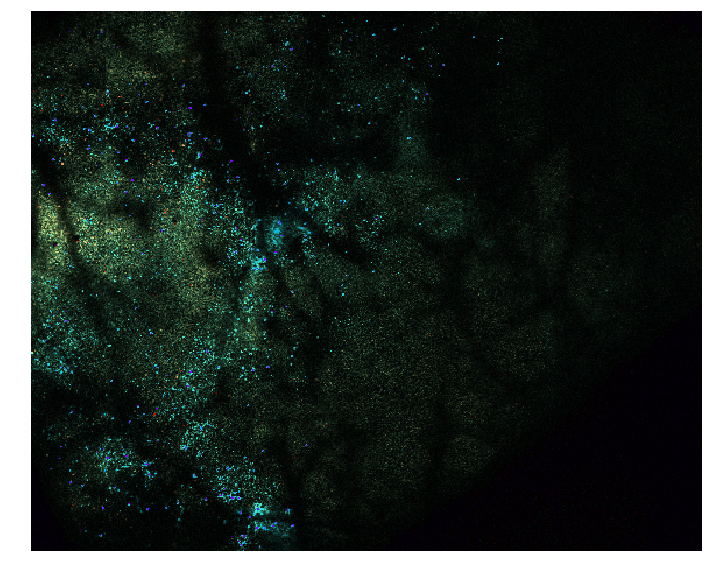

In [355]:
image(mapped.clip(0,1), size=12);

In [356]:
imsave(savepath+'/tuneCorPosAD.tif', (255*mapped.clip(0,1)).astype('uint8'), plugin='tifffile', photometric='rgb')

###overlay

In [357]:
overlay = maximum(mapped_corpos, mapped_speed)

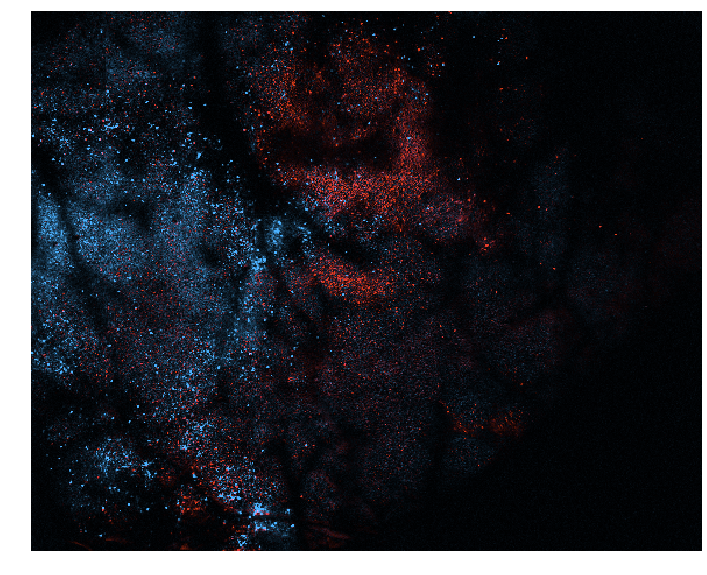

In [358]:
image(overlay, size=12)

In [359]:
imsave(savepath+'/rsqOverlayD.tif', (255*overlay).astype('uint8'), plugin='tifffile', photometric='rgb')

In [360]:
overlayR = maximum(mapped_corposR, mapped_speed)

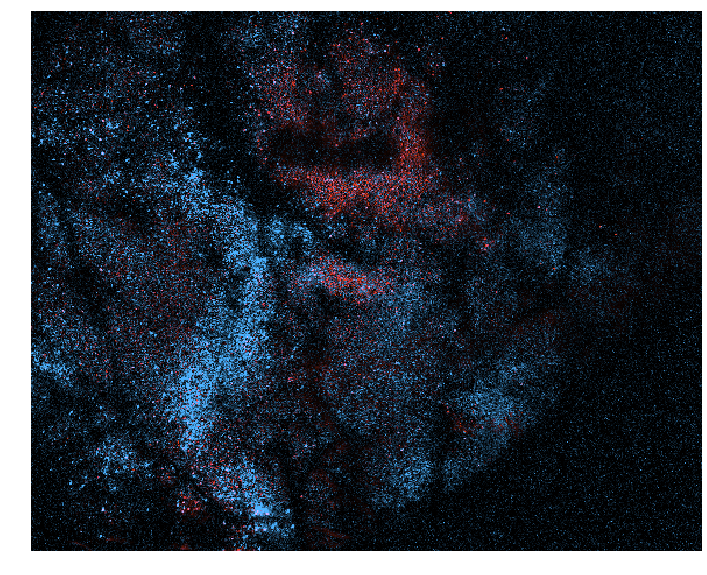

In [361]:
image(overlayR, size=12)

In [362]:
imsave(savepath+'/rsqOverlayRD.tif', (255*overlayR).astype('uint8'), plugin='tifffile', photometric='rgb')

### localcorr map

In [363]:
localcorr = detrended.localcorr((4, 4)).astype('float32')
#localcorr = detrended.localcorr((1, 4, 4)).astype('float32')

In [364]:
imsave(savepath+'/localcorrD.tif', localcorr, plugin='tifffile', photometric='minisblack')

In [365]:
#localcorr = imread(savepath+'/localcorrD.tif')

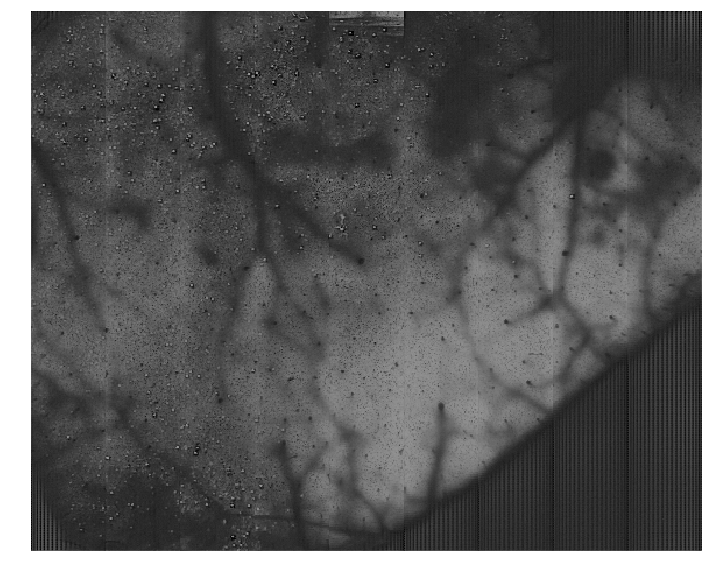

In [366]:
image(localcorr, clim=(0, 3.5*localcorr.mean()), size=12)

In [367]:
cmap = LinearSegmentedColormap.from_list('blend', [[0, 0, 0], [0.1, 1.0, 0.2]])
mapped_localcorr = make_rsq_map(localcorr, vmin=0.5, vmax=0.9, cmap=cmap)
#mapped_localcorr = asarray([make_rsq_map(x, vmin=0.5, vmax=0.9, cmap=cmap) for x in localcorr])

##overlay

In [368]:
overlay = maximum(maximum(mapped_corpos, mapped_speed), mapped_localcorr)

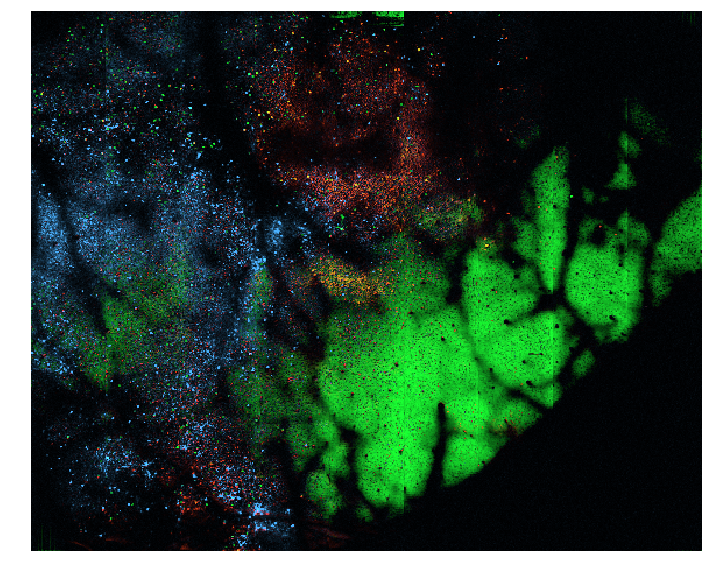

In [369]:
image(overlay, size=12);

In [370]:
imsave(savepath+'/rsqOverlayLCD.tif', (255*overlay).astype('uint8'), plugin='tifffile', photometric='rgb')

In [371]:
overlayR = maximum(maximum(mapped_corposR, mapped_speed), mapped_localcorr)

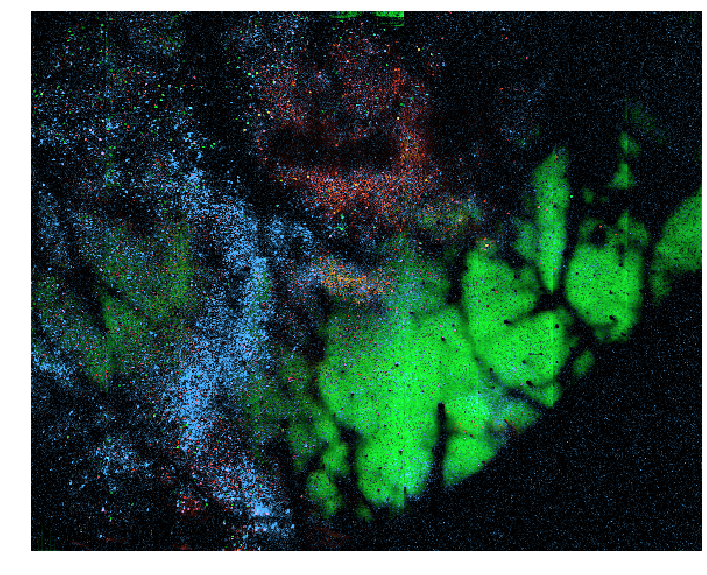

In [372]:
image(overlayR, size=12);

In [373]:
imsave(savepath+'/rsqOverlayLCRD.tif', (255*overlayR).astype('uint8'), plugin='tifffile', photometric='rgb')

##tuning curves

In [374]:
#plt.plot(betasA[123,10,1,:])

In [375]:
#fig = plt.figure(figsize=[10,10])
#ax = plt.axes()
#im = image(betasA[:,:,0,2] - betasA[:,:,0,5], clim=(-125, 125), ax=ax)